# **Step 1: Environment & Input Data Setup**

## **Packages & Libraries**

In [4]:
!pip install contractions
!pip install demoji

In [63]:
# Dataset Libraries
import pandas as pd
import numpy as np

# Preprocessing Libraries
import re
import contractions
from collections import defaultdict
import demoji

# Visualization Libraries
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# ML and Evaluation Libraries

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split, GridSearchCV

# Torch ML Libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import RobertaModel, RobertaTokenizer
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, DistilBertConfig
from transformers import DistilBertModel, DistilBertTokenizer
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DataCollatorWithPadding
from sklearn.utils.class_weight import compute_class_weight

# Other Libraries
import warnings
import time

# Ignore all warnings
warnings.filterwarnings("ignore")

# For inline plotting in Jupyter Notebooks
%matplotlib inline

**Number of available GPU**

In [6]:
print("Available GPUs:", torch.cuda.device_count())

Available GPUs: 2


## **Load Wex Reviews Input Dataset**

* The dataset is not cleaned but balanced. 
* It is the similar input dataset used in supervised ML pipeline
* This dataset roughly has ~7k per rating records from Trust pilot, Powerreviews and some kaggle reviews dataset containing neutral reviews since there are not many neutral / negative reviews for wex on their respective reviews platforms.
* The dataset has 3 columns currently: Rating, Content and Source

In [28]:
df = pd.read_csv("/kaggle/input/bert-3-label-input-data-raw/bert_final_3label.csv")

In [29]:
df.head()

,Rating,Content,Source
0,4,Not sure yet. Don't have the item,PowerReviews
1,4,It would be nice if I could finish shopping be...,PowerReviews
2,4,"Seemless, so far. Need to wait for delivery to...",PowerReviews
3,4,Website slow.,PowerReviews
4,4,EASY TO USE ONLINE SYSTEM,PowerReviews


In [30]:
df['Rating'].value_counts()

Rating
3    9315
5    4699
4    4698
1    4698
2    4686
Name: count, dtype: int64

## **Create Sentiments**

In [31]:
def create_sentiment_labels(rating):
    rating = int(rating)

    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [32]:
def apply_sentiment_to_test_data():
    # Apply to the dataset
    df['Sentiment'] = df['Rating'].apply(create_sentiment_labels)

apply_sentiment_to_test_data()

### **Verify Sentiments created**

Sentiment 0 == Rating 1 and 2 

Sentiment 1 == Rating 3

Sentiment 2 == Rating 4 and 5

In [33]:
df.head()

,Rating,Content,Source,Sentiment
0,4,Not sure yet. Don't have the item,PowerReviews,2
1,4,It would be nice if I could finish shopping be...,PowerReviews,2
2,4,"Seemless, so far. Need to wait for delivery to...",PowerReviews,2
3,4,Website slow.,PowerReviews,2
4,4,EASY TO USE ONLINE SYSTEM,PowerReviews,2


In [34]:
df['Sentiment'].value_counts()

Sentiment
2    9397
0    9384
1    9315
Name: count, dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28096 entries, 0 to 28095
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rating     28096 non-null  int64 
 1   Content    28096 non-null  object
 2   Source     28096 non-null  object
 3   Sentiment  28096 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 878.1+ KB


In [36]:
df['Rating'].value_counts()

Rating
3    9315
5    4699
4    4698
1    4698
2    4686
Name: count, dtype: int64

# **Step 2: Input Data Cleaning & Pre-processing**

* Lowercasing - YES
* Emoji Replacement - YES
* Contractions Handling - YES
* Punctuations / Links / Brackets Handling - YES
* Unwanted Spaces Cleaning
* Special Char Removal
* Duplicate Records Removal
* Lemmatization - **NO**

## **Lowercasing**

In [37]:
df_balanced['Content'] = df_balanced['Content'].str.lower()
# Verification
df_balanced.head(20)

,Unnamed: 0,Rating,Content,Source,Sentiment,cleaned_emoji
0,18414,2,"i ordered a phone and received it just fine, h...",Kaggle Comp,0,"i ordered a phone and received it just fine, h..."
1,3263,4,"easy to navigate website, prompt delivery and ...",Trustpilot,2,"easy to navigate website, prompt delivery and ..."
2,18640,2,"item hasn’t arrived, two failed communications...",Kaggle Comp,0,"item hasn’t arrived, two failed communications..."
3,21757,1,absolutely terrible treatment from the staff a...,Kaggle,0,absolutely terrible treatment from the staff a...
4,3557,4,spot on with the view on the condition of the ...,Trustpilot,2,spot on with the view on the condition of the ...
5,9162,3,"beautiful detail, soft drapey fabric. but it p...",Kaggle Ecom,1,"beautiful detail, soft drapey fabric. but it p..."
6,20676,2,i noticed at the end that i have to opt out of...,PowerReviews,0,i noticed at the end that i have to opt out of...
7,19696,2,guess i should've looked at the pictures more ...,Kaggle Ecom,0,guess i should've looked at the pictures more ...
8,19735,2,"so, i want to start off by saying, the quality...",Kaggle Ecom,0,"so, i want to start off by saying, the quality..."
9,17564,1,i'll stop using the site if you don't pack in ...,PowerReviews,0,i'll stop using the site if you don't pack in ...


## **Emoji Replacement**

In [38]:
def find_emoji(text):
    emoj = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
                  "]+", re.UNICODE)

    if len(str(text))<2:
        emoji_dict = demoji.findall(text)
        for key, value in emoji_dict.items():
            return value
    else:
        demoji.findall(str(text))
        values_list  = []
        for keys, values in demoji.findall(str(text)).items():
            values_list.append(values)

        if "star" in values_list:
            return re.sub(emoj, 'star', str(text))

        emoji_removed = re.sub(emoj, '', str(text))
        return emoji_removed

In [39]:
df_balanced["cleaned_emoji"] = df_balanced["Content"].apply(find_emoji)
emojis_found = df_balanced["cleaned_emoji"].isnull().sum()
print(f"Emoji Records to be removed: {emojis_found}")
df_balanced = df_balanced.dropna()
print("Emojis, Symbols, Chinese Chracters, Flags etc. removed successfully")

Emoji Records to be removed: 0
Emojis, Symbols, Chinese Chracters, Flags etc. removed successfully


In [40]:
# Verification
df_balanced.head(20)

,Unnamed: 0,Rating,Content,Source,Sentiment,cleaned_emoji
0,18414,2,"i ordered a phone and received it just fine, h...",Kaggle Comp,0,"i ordered a phone and received it just fine, h..."
1,3263,4,"easy to navigate website, prompt delivery and ...",Trustpilot,2,"easy to navigate website, prompt delivery and ..."
2,18640,2,"item hasn’t arrived, two failed communications...",Kaggle Comp,0,"item hasn’t arrived, two failed communications..."
3,21757,1,absolutely terrible treatment from the staff a...,Kaggle,0,absolutely terrible treatment from the staff a...
4,3557,4,spot on with the view on the condition of the ...,Trustpilot,2,spot on with the view on the condition of the ...
5,9162,3,"beautiful detail, soft drapey fabric. but it p...",Kaggle Ecom,1,"beautiful detail, soft drapey fabric. but it p..."
6,20676,2,i noticed at the end that i have to opt out of...,PowerReviews,0,i noticed at the end that i have to opt out of...
7,19696,2,guess i should've looked at the pictures more ...,Kaggle Ecom,0,guess i should've looked at the pictures more ...
8,19735,2,"so, i want to start off by saying, the quality...",Kaggle Ecom,0,"so, i want to start off by saying, the quality..."
9,17564,1,i'll stop using the site if you don't pack in ...,PowerReviews,0,i'll stop using the site if you don't pack in ...


## **Contractions Handling**

In [41]:
def find_contractions(text):
    # Removing Contractions
    expanded_text = []
    for word in text.split():
        expanded_text.append(contractions.fix(word))

    expanded_text = ' '.join(expanded_text)
    return expanded_text

In [42]:
df_balanced["contractions_removed"] = df_balanced["cleaned_emoji"].apply(find_contractions)
print("Contractions removed successfully")

Contractions removed successfully


In [43]:
# Verification
df_balanced.head(20)

,Unnamed: 0,Rating,Content,Source,Sentiment,cleaned_emoji,contractions_removed
0,18414,2,"i ordered a phone and received it just fine, h...",Kaggle Comp,0,"i ordered a phone and received it just fine, h...","i ordered a phone and received it just fine, h..."
1,3263,4,"easy to navigate website, prompt delivery and ...",Trustpilot,2,"easy to navigate website, prompt delivery and ...","easy to navigate website, prompt delivery and ..."
2,18640,2,"item hasn’t arrived, two failed communications...",Kaggle Comp,0,"item hasn’t arrived, two failed communications...","item has not arrived, two failed communication..."
3,21757,1,absolutely terrible treatment from the staff a...,Kaggle,0,absolutely terrible treatment from the staff a...,absolutely terrible treatment from the staff a...
4,3557,4,spot on with the view on the condition of the ...,Trustpilot,2,spot on with the view on the condition of the ...,spot on with the view on the condition of the ...
5,9162,3,"beautiful detail, soft drapey fabric. but it p...",Kaggle Ecom,1,"beautiful detail, soft drapey fabric. but it p...","beautiful detail, soft drapey fabric. but it p..."
6,20676,2,i noticed at the end that i have to opt out of...,PowerReviews,0,i noticed at the end that i have to opt out of...,i noticed at the end that i have to opt out of...
7,19696,2,guess i should've looked at the pictures more ...,Kaggle Ecom,0,guess i should've looked at the pictures more ...,guess i should have looked at the pictures mor...
8,19735,2,"so, i want to start off by saying, the quality...",Kaggle Ecom,0,"so, i want to start off by saying, the quality...","so, i want to start off by saying, the quality..."
9,17564,1,i'll stop using the site if you don't pack in ...,PowerReviews,0,i'll stop using the site if you don't pack in ...,i will stop using the site if you do not pack ...


## **Punctuations / Links / Brackets Handling**

In [44]:
def find_brackets_links_punctuations(text):
    text = text.lower() #lowercases the string
    text = re.sub(r"\.{2,}",".", text) #removes trailing ...
    text = re.sub(r"\!{2,}","!", text) #removes trailing !!!
    text = re.sub(r"\+{2,}","", text) #removes trailing +++
    text = re.sub(r"\?{2,}","?", text) #removes trailing ???
    text = re.sub(r"\_{2,}"," ", text) #removes trailing ___
    text = re.sub(r"[\[\]]", '', text) #removes [ or ]
    text = re.sub(r"\(.*?\)", '', text) #removes (text)
    text = re.sub(r'["“”]', '', text) #removes quotation maeks ""
    text = re.sub(r'(\w)\1+', r'\1\1', text) #removes repeating characters and repaces it with 2 occurances
    text = re.sub(r'\*', '', text) #removes *
    text = re.sub(r"\s*([.])\s*", '. ', text) #removes whitespaces for .
    text = re.sub(r"\s*([,])\s*", ', ', text) #removes whitespaces for ,
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #removes links

    return text

In [45]:
df_balanced["regex"] = df_balanced["contractions_removed"].apply(find_brackets_links_punctuations)
df_balanced = df_balanced.drop(df_balanced.loc[df_balanced["regex"].str.len() < 2].index)
df_balanced = df_balanced.dropna()
print("Brackets, Links, Numbers in text or Punctuations removed succesfully")

Brackets, Links, Numbers in text or Punctuations removed succesfully


## **Unwanted Spaces Cleaning**

In [46]:
def find_unwanted_spaces(text):
    return text.strip()

In [47]:
df_balanced["regex"] = df_balanced["regex"].apply(find_unwanted_spaces)
df_balanced = df_balanced.drop(df_balanced.loc[df_balanced["regex"].str.len() < 2].index)
df_balanced.loc[df_balanced["regex"].str.len() < 3].regex.value_counts()
df_balanced.loc[(df_balanced["regex"] != "ok") & (df_balanced["regex"].str.len() < 3)].value_counts()
df_balanced = df_balanced.drop(df_balanced.loc[(df_balanced["regex"] != "ok") & (df_balanced["regex"].str.len() < 3)].index)
df_balanced[df_balanced["regex"].str.len() < 3]
print("Unwanted trailing spaces removed successfully")

Unwanted trailing spaces removed successfully


## **Special Characters Removal**

In [48]:
# Remove more meaningless special characters
def find_special_char(text):
    if len(text)<4:
        text = text.strip()
        text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return text

In [49]:
df_balanced['regex'] = df_balanced['regex'].apply(find_special_char)
df_balanced.loc[df_balanced["regex"].str.len() < 10].regex.value_counts()
df_balanced['regex'] = df_balanced['regex'].astype(str)
df_balanced.drop(columns = ['cleaned_emoji', 'contractions_removed'], inplace = True)
print("Special Characters removed successfully")

Special Characters removed successfully


In [50]:
# Verification
df_balanced.head()

,Unnamed: 0,Rating,Content,Source,Sentiment,regex
0,18414,2,"i ordered a phone and received it just fine, h...",Kaggle Comp,0,"i ordered a phone and received it just fine, h..."
1,3263,4,"easy to navigate website, prompt delivery and ...",Trustpilot,2,"easy to navigate website, prompt delivery and ..."
2,18640,2,"item hasn’t arrived, two failed communications...",Kaggle Comp,0,"item has not arrived, two failed communication..."
3,21757,1,absolutely terrible treatment from the staff a...,Kaggle,0,absolutely terrible treatment from the staff a...
4,3557,4,spot on with the view on the condition of the ...,Trustpilot,2,spot on with the view on the condition of the ...


## **Duplicate Records Removal**

In [51]:
print("\nShape of the DataFrame before dropping duplicate rows:", df_balanced.shape)
duplicate = df_balanced[df_balanced.duplicated('regex')]
df_balanced = df_balanced.drop_duplicates(subset=['Content', 'regex'])
print("Duplicate records removed successfully from pre-processed data")
print("\nShape of the DataFrame after dropping duplicate rows:", df_balanced.shape)


Shape of the DataFrame before dropping duplicate rows: (23348, 6)
Duplicate records removed successfully from pre-processed data

Shape of the DataFrame after dropping duplicate rows: (18823, 6)


## **Drop Regex Column**

In [52]:
# Replace Content with regex column
df_balanced.drop(columns = ['Content'], inplace = True)
df_balanced = df_balanced.rename(columns={'regex': 'Content'})
print("Regex column dropped successfully")

Regex column dropped successfully


In [53]:
# Verification
df_balanced.head()

,Unnamed: 0,Rating,Source,Sentiment,Content
0,18414,2,Kaggle Comp,0,"i ordered a phone and received it just fine, h..."
1,3263,4,Trustpilot,2,"easy to navigate website, prompt delivery and ..."
2,18640,2,Kaggle Comp,0,"item has not arrived, two failed communication..."
3,21757,1,Kaggle,0,absolutely terrible treatment from the staff a...
4,3557,4,Trustpilot,2,spot on with the view on the condition of the ...


## **Save Pre-processed Data**

In [54]:
df_balanced['Content'] = df_balanced['Content'].astype(str)
df_balanced.to_csv('/kaggle/working/cleaned_bert_final_3label.csv', index=False)
print("Test Data Pre-processed and saved successfully.")

Test Data Pre-processed and saved successfully.


# **BERT Model Creation & Training**

**Cleaned Input Dataset**

In [55]:
df = pd.read_csv("/kaggle/working/cleaned_bert_final_3label.csv")

Converting all reviews to string

In [60]:
df['Content'] = df['Content'].astype(str)

## **References:-**

- https://tinkerd.net/blog/machine-learning/bert-tokenization/#demo-bert-tokenizer
- https://discuss.huggingface.co/t/sentence-splitting/5393
- https://juditacs.github.io/2019/02/19/bert-tokenization-stats.html

Important Reference: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [67]:
fig = px.histogram(df,x="Sentiment", color='Sentiment', title = 'Sentiment Distribution', labels={'x': 'Sentiment', 'y': 'Frequency'})
fig.update_layout(bargap=0.2)
fig.show()

## **Model Creation:-**

**Using DistilBERT**
* Smaller BERT model
* Lighter and Faster than roBERTa, BERT base models
* Better for resource contrained environments

**Batch Size**: No. of training records/samples per batch

**Max Len**: Max length of tokens of input data fed to model for training.

**Epoch**: One complete loop on entire training dataset.

**Learning Rate**: Step size to update model's parameters during training.

**Dropout Rate**: To avoid model overfitting. 

In [68]:
# Setting the Batch Size, Max Length, Learning Rate, Dropout Rate
NAME = "db" #b for BERT, #rb for RoBERTa, #db for DistilBERT, #dbseq for DistilBERTforSequenceClassification
BATCH_SIZE = 64
MAX_LEN = 512 #changed from 512 for batch size 64, otherwise it would give error
EPOCHS = 8
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.3 #[0.3, 0.4, 0.5] #considered dropout of 0.3 already

**Loading DistilBERT Model**

About DistilBERT: 
- https://ysu1989.github.io/courses/au20/cse5539/DistilBERT.pdf
- https://huggingface.co/docs/transformers/en/model_doc/distilbert

In [70]:
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=DROPOUT_RATE)
        #self.additional_layer = nn.Linear(2, 64)  # Additional features layer
        self.out = nn.Linear(self.distilbert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[0][:, 0, :]  # Use the [CLS] token embedding
        output = self.drop(pooled_output)
        return self.out(output)

In [71]:
# Store length of each review
token_lens = []

# Storing token lengths
for txt in df.Content:
    tokens = tokenizer.encode(txt, max_length=512, truncation = True)
    token_lens.append(len(tokens))

In [72]:
token_df = pd.DataFrame(token_lens, columns = ['Tokens'])
plot_names = token_df['Tokens'].value_counts().keys()
plot_values = token_df['Tokens'].value_counts().values

In [73]:
# Bar plot for reviews token distribution
fig = go.Figure(data=[
    go.Bar(
        name='True Labels',
        x=plot_names,
        y=plot_values)
    ])

fig.show()

## **Train/Test/Val Split:-**

In [74]:
# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Create train, validation, and test splits (90/5/5 split)
df_train, df_temp = train_test_split(df, test_size=0.1, random_state=42, stratify=df['Sentiment'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['Sentiment'])
print(len(df_train), len(df_val), len(df_test))

16940 941 942


**Total Input Data**: 18,823

**Training Data**: 16,940 (90%)

**Val Data**: 941 (~5%)

**Test Data**: 942 (~5%)

In [76]:
print(df_train.Sentiment.value_counts(), df_val.Sentiment.value_counts(), df_test.Sentiment.value_counts())

Sentiment
0    6854
2    5106
1    4980
Name: count, dtype: int64 Sentiment
0    381
2    284
1    276
Name: count, dtype: int64 Sentiment
0    381
2    284
1    277
Name: count, dtype: int64


#### **Total Input Data**: 18,823

#### **Training Data Setiment Distribution (90%)**:

**Label 0 (Rating 1 & 2)**: 6854 | 
**Label 1 (Rating 3)**: 4980 | 
**Label 2 (Rating 4 & 5)**: 5106 | 


#### **Validation Data Sentiment Distribution (~5%)**:

**Label 0 (Rating 1 & 2)**: 381 | 
**Label 1 (Rating 3)**: 276 | 
**Label 2 (Rating 4 & 5)**: 284 | 

#### **Test Data Sentiment Distribution (~5%)**:
**Label 0 (Rating 1 & 2)**: 381 | 
**Label 1 (Rating 3)**: 277 | 
**Label 2 (Rating 4 & 5)**: 284 | 

## **Model Training**

In [77]:
class GPReviewDataset(Dataset):
    #def __init__(self, reviews, targets, tokenizer, max_len, additional_features):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        #self.additional_features = additional_features

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        #additional_features = self.additional_features[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            #'additional_features': torch.tensor(additional_features, dtype=torch.float),
            'targets': torch.tensor(target, dtype=torch.long)
        }
    
    
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df['Content'].to_numpy(),
        targets=df['Sentiment'].to_numpy(),
        tokenizer=tokenizer,
        #additional_features=df[['text_length', 'word_count', 'avg_word_length', 'sentiment_score']].values,
        max_len=max_len    
    )

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    return DataLoader(ds, batch_size=batch_size, num_workers=0, collate_fn=data_collator)

# Training function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    correct_predictions = 0
    total_loss = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        #additional_features = d["additional_features"].to(device)
        targets = d["targets"].to(device)

        #outputs = model(input_ids=input_ids, attention_mask=attention_mask, additional_features=additional_features)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets)
        total_loss += loss.item()

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    return correct_predictions.double() / n_examples, total_loss / n_examples

# Evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    correct_predictions = 0
    total_loss = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            #additional_features = d["additional_features"].to(device)
            targets = d["targets"].to(device)

            #outputs = model(input_ids=input_ids, attention_mask=attention_mask, additional_features=additional_features)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == targets)
            total_loss += loss.item()

    model.train()
    return correct_predictions.double() / n_examples, total_loss / n_examples

In [78]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [79]:
# Define a DataFrame to store results
results_df = pd.DataFrame(columns=['Epochs', 'Batch Size', 'Learning Rate', 'Dropout Rate', 'Train Accuracy', 'Train Loss', 'Val Accuracy', 'Val Loss','Test Accuracy', 'Max Length'])

In [81]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Initialize the model, optimizer, and scheduler
model = SentimentClassifier(n_classes=3)
# Load the model
model = model.to(device)
model = nn.DataParallel(model) ## LIFESAVER!!

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100, #changing wramup steps to 100
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [82]:
for d in train_data_loader:
    print(d.keys())
    break

dict_keys(['input_ids', 'attention_mask', 'targets'])


In [84]:
# Model name and output path
PATH = f"/kaggle/working/model_{BATCH_SIZE}_{MAX_LEN}_{EPOCHS}_{DROPOUT_RATE}_{NAME}_3label.pth"

In [85]:
%%time
# Early stopping parameters
early_stopping_patience = 3
best_val_acc = 0.0
patience_counter = 0

progress_bar = tqdm(range(total_steps))

# Training loop with history tracking and early stopping
history = defaultdict(list)
learning_rates = []

# Initialize a list to store each experiment's results as DataFrames
results_list = []

print(f"Batch Size: {BATCH_SIZE}")
print()

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    start_time = time.time()  # Start timer

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    val_acc, val_loss = eval_model(
                model,
                val_data_loader,
                loss_fn,
                device,
                len(df_val)
            )

    end_time = time.time()  # End timer
    epoch_duration = end_time - start_time  # Calculate epoch duration

    # Record the learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Store history
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    history['epoch_time'].append(epoch_duration)  # Store epoch duration

    print(f"Train loss {train_loss} accuracy {train_acc}")
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print(f"Learning Rate: {current_lr}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print()
    
    # Early stopping logic based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.module.state_dict(), PATH)
        
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

  0%|          | 0/2120 [00:00<?, ?it/s]

Batch Size: 64

Epoch: 1/8
----------
Train loss 0.011427068865144408 accuracy 0.6519480519480519
Val   loss 0.009885843831345074 accuracy 0.7077577045696067
Learning Rate: 1.8366336633663368e-05

Epoch: 2/8
----------
Train loss 0.008452601086924461 accuracy 0.7589728453364817
Val   loss 0.00981933705104905 accuracy 0.7215727948990436
Learning Rate: 1.5742574257425743e-05

Epoch: 3/8
----------
Train loss 0.007154521694431057 accuracy 0.8024793388429753
Val   loss 0.010447424194131217 accuracy 0.720510095642933
Learning Rate: 1.311881188118812e-05

Epoch: 4/8
----------
Train loss 0.0059679058772965895 accuracy 0.8440377804014167
Val   loss 0.011404485112168964 accuracy 0.7300743889479276
Learning Rate: 1.0495049504950497e-05

Epoch: 5/8
----------
Train loss 0.004960067342381832 accuracy 0.8731995277449823
Val   loss 0.011166674677801183 accuracy 0.7396386822529224
Learning Rate: 7.871287128712872e-06

Epoch: 6/8
----------
Train loss 0.004066185367325543 accuracy 0.8994096812278631


## **Model Evaluation**

In [86]:
%%time
# Evaluate on test data
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

results_list = []

# Save results for this strategy
experiment_results = pd.DataFrame({
    #'Strategy': ["Linear Warmup"],
    'Epochs': [EPOCHS],
    'Batch Size': [BATCH_SIZE],
    'Learning Rate': [LEARNING_RATE],
    #'Warm-Up Steps': [0],
    'Dropout Rate': [DROPOUT_RATE],
    'Train Accuracy': [max(history['train_acc'])],
    'Train Loss' : [min(history['train_loss'])],
    'Val Accuracy': [max(history['val_acc'])],
    'Val Loss' : [min(history['val_loss'])],
    'Test Accuracy': [test_acc.item()],
    'Max Length': [MAX_LEN]
})

print(test_acc.item())

results_list.append(experiment_results)

0.7080679405520169
CPU times: user 10.7 s, sys: 33 ms, total: 10.7 s
Wall time: 10.6 s


In [87]:
results_list

[   Epochs  Batch Size  Learning Rate  Dropout Rate  Train Accuracy  \
 0       8          64        0.00002           0.3        0.929457   
 
    Train Loss  Val Accuracy  Val Loss  Test Accuracy  Max Length  
 0    0.002996      0.739639  0.009819       0.708068         512  ]

### **Result Summary**

**Epoch**: 8 | **Batch Size**: 64 | **Learning Rate**: 0.00002 / 2e-5 | **Dropout Rate**: 0.3 

#### **Accuracies**:-

**Train Accuracy**: 92.9% (~93%)

**Validation Accuracy**: 73.9% (~74%)

**Test Accuracy**: 70.8% (~71%)

#### **Loss**:-

**Train Loss**: ~0.2%
**Validation Loss**: ~0.9%

## **Save Model Results to CSV**

In [92]:
results_df = pd.concat(results_list, ignore_index=True, axis = 0)
results_df.to_csv(f"/kaggle/working/result_{BATCH_SIZE}_{MAX_LEN}_{EPOCHS}_{DROPOUT_RATE}_{NAME}_3label.csv", index = False) #kaggle directory

## **Model Prediction on Validation Dataset**

In [89]:
%%time
all_preds = []
all_targets = []

with torch.no_grad():
    for d in val_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)  # Assuming 'targets' column is 'labels'
        #additional_features = d["additional_features"].to(device)

        #outputs = model(input_ids=input_ids, attention_mask=attention_mask, additional_features=additional_features)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        if isinstance(outputs, tuple):
            logits = outputs[0]
        else:
            logits = outputs

        _, preds = torch.max(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        
        # Clear GPU cache
        torch.cuda.empty_cache()

CPU times: user 11.2 s, sys: 954 ms, total: 12.1 s
Wall time: 12 s


In [90]:
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

### **Validation Dataset Classification Report**

In [91]:
# model's performance
print(classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       0.72      0.73      0.73       381
           1       0.56      0.58      0.57       276
           2       0.90      0.86      0.88       284

    accuracy                           0.72       941
   macro avg       0.73      0.72      0.72       941
weighted avg       0.73      0.72      0.73       941



### **Validation Dataset Confusion Matrix**

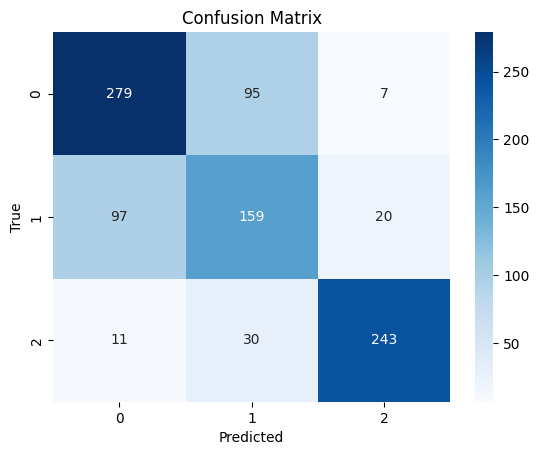

In [93]:
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2])  # Replace with your actual labels

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])  # Replace with your actual labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Summary**: The model seems to be confused around label 1 that is Rating 3 (Neutral reviews). It is doing a pretty good job around label 0 i.e reviews having rating 1 and 2. 

## **Model Prediction on Test Dataset**

In [94]:
%%time
all_preds = []
all_targets = []

with torch.no_grad():
    for d in test_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)  # Assuming 'targets' column is 'labels'
        #additional_features = d["additional_features"].to(device)

        #outputs = model(input_ids=input_ids, attention_mask=attention_mask, additional_features=additional_features)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        if isinstance(outputs, tuple):
            logits = outputs[0]
        else:
            logits = outputs

        _, preds = torch.max(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        
        # Clear GPU cache
        torch.cuda.empty_cache()

CPU times: user 11.1 s, sys: 759 ms, total: 11.8 s
Wall time: 11.7 s


In [95]:
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

### **Test Dataset Classification Report**

In [96]:
# model's performance
print(classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71       381
           1       0.52      0.52      0.52       277
           2       0.86      0.85      0.85       284

    accuracy                           0.70       942
   macro avg       0.70      0.69      0.70       942
weighted avg       0.70      0.70      0.70       942



### **Test Dataset Confusion Matrix**

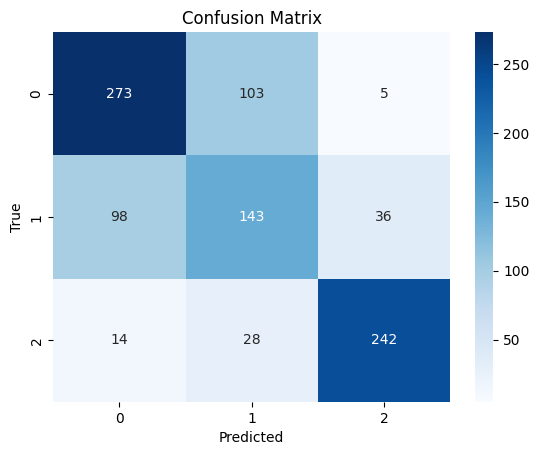

In [97]:
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2])  # Replace with your actual labels

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])  # Replace with your actual labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Summary**: Same as validation dataset performance. The model seems to be confused around label 1 that is Rating 3 (Neutral reviews). It is doing a pretty good job around label 0 i.e reviews having rating 1 and 2. 

### **Plots - Train vs Val Accuracy | Train vs Val Loss**

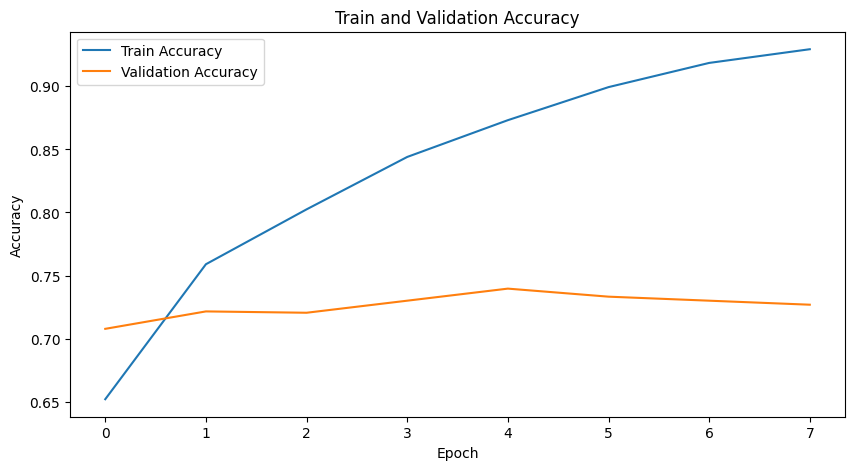

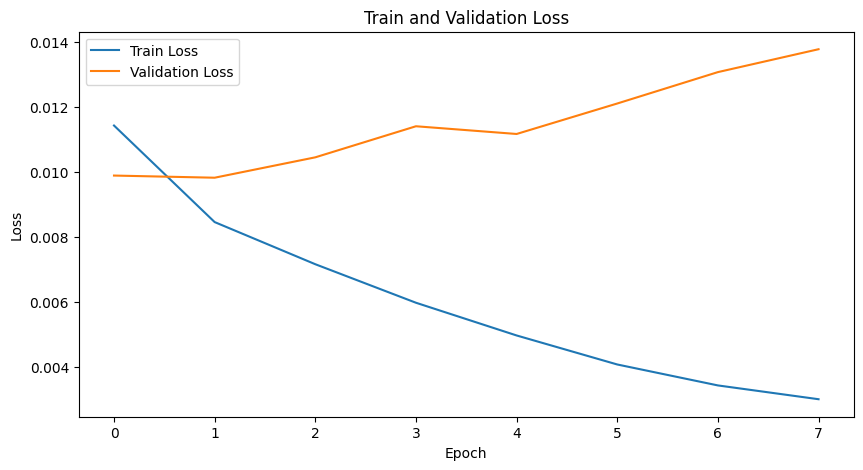

In [98]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.ylim([0, 1])
plt.show()


# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.ylim([0, 1])
plt.show()

**Summary**: The training accuracy increases per epoch. The validation accuracy seems to be pretty constant accross all epochs. Only a slight increase is noticeable. 
The training loss seems to be significantly decreasing per epoch whereas un-expectedly val loss is increasing per epoch. However, not by huge margin. 

## **Training History**

**Reference**: https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict-or-any-other-python-object?noredirect=1&lq=1

In [99]:
# Saving History
import pickle
print(history)
with open(f"/kaggle/working/history_{BATCH_SIZE}_{MAX_LEN}_{EPOCHS}_{DROPOUT_RATE}_{NAME}_3label.pickle", 'wb') as file_pi:
    pickle.dump(history, file_pi, protocol=pickle.HIGHEST_PROTOCOL)

defaultdict(<class 'list'>, {'train_acc': [0.6519480519480519, 0.7589728453364817, 0.8024793388429753, 0.8440377804014167, 0.8731995277449823, 0.8994096812278631, 0.9185950413223141, 0.929456906729634], 'train_loss': [0.011427068865144408, 0.008452601086924461, 0.007154521694431057, 0.0059679058772965895, 0.004960067342381832, 0.004066185367325543, 0.003420923157884281, 0.0029959281235757374], 'val_acc': [0.7077577045696067, 0.7215727948990436, 0.720510095642933, 0.7300743889479276, 0.7396386822529224, 0.7332624867162593, 0.7300743889479276, 0.7268862911795961], 'val_loss': [0.009885843831345074, 0.00981933705104905, 0.010447424194131217, 0.011404485112168964, 0.011166674677801183, 0.01210541793567848, 0.0130724875883899, 0.013777567526992652]})


## **Saving Model**

**Reference**:- 

https://stackoverflow.com/questions/59340061/saving-a-fine-tuned-bert-model
https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [100]:
PATH = f"/kaggle/working/model_{BATCH_SIZE}_{MAX_LEN}_{EPOCHS}_{DROPOUT_RATE}_{NAME}_3label.pth"
torch.save(model.module.state_dict(), PATH)

## **Model Predictions on External Test Dataset**

**Mandatory Libraries / Packages**

In [101]:
!pip install contractions demoji

In [102]:
# Dataset Libraries
import pandas as pd
import numpy as np

# Preprocessing Libraries
import re
import contractions
from collections import defaultdict
import demoji

# Torch ML Libraries
import transformers
from transformers import DistilBertModel, DistilBertTokenizer
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Sklearn Libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# Visualization Libraries
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
demoji.download_codes()

In [103]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Loading Saved Model**

In [104]:
# Setting the Batch Size, Max Length, Learning Rate, Dropout Rate
NAME = "db" #b for BERT, #rb for RoBERTa, #db for DistilBERT, #dbseq for DistilBERTforSequenceClassification
BATCH_SIZE = 64
MAX_LEN = 512 #changed from 512 for batch size 64, otherwise it would give error
EPOCHS = 8
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.3 #[0.3, 0.4, 0.5] #considered dropout of 0.3 already

In [105]:
# DistilBERT
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# BERT base
#MODEL_NAME = 'bert-base-cased'
#tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.distilbert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[0][:, 0, :]  # Use the [CLS] token embedding
        output = self.drop(pooled_output)
        return self.out(output)

In [106]:
saved_model = SentimentClassifier(n_classes=3)
saved_model.load_state_dict(torch.load("/kaggle/input/bert-3-label-model-final/model_64_512_8_0.3_db_3label.pth"))
saved_model = saved_model.to(device)
saved_model = nn.DataParallel(saved_model) ## LIFESAVER!!
saved_model.eval()

DataParallel(
  (module): SentimentClassifier(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
      

### **Loading External Dataset**

In [107]:
PATH_TESTING = "/kaggle/input/external-test-data-cleaned/cleaned_reviews_approach3.csv"
test_df = pd.read_csv(PATH_TESTING)
test_df.Content = test_df.Content.astype(str)

In [108]:
test_df.head()

,Rating,Source,Sentiment,Content,word_count
0,4.0,PowerReviews,2,not sure yet. do not have the item,8
1,4.0,PowerReviews,2,it would be nice if i could finish shopping be...,14
2,4.0,PowerReviews,2,"seemless, so far. need to wait for delivery to...",12
3,4.0,PowerReviews,2,website slow.,2
4,4.0,PowerReviews,2,easy to use online system,5


In [109]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20748 entries, 0 to 20747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rating      20748 non-null  float64
 1   Source      20748 non-null  object 
 2   Sentiment   20748 non-null  int64  
 3   Content     20748 non-null  object 
 4   word_count  20748 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 810.6+ KB


In [110]:
fig = px.histogram(test_df,x="Sentiment", color='Sentiment', title = 'Sentiment Distribution', labels={'x': 'Sentiment', 'y': 'Frequency'})
fig.update_layout(bargap=0.2)
fig.show()

### **Tokenize the dataset**

In [114]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.Content.to_numpy(),
        targets=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=0)

In [115]:
# Store length of each review
token_lens = []

# Storing token lengths
for txt in test_df.Content:
    tokens = tokenizer.encode(txt, max_length=512, truncation = True)
    token_lens.append(len(tokens))
    
token_df = pd.DataFrame(token_lens, columns = ['Tokens'])
plot_names = token_df['Tokens'].value_counts().keys()
plot_values = token_df['Tokens'].value_counts().values

# Create the plot
fig = go.Figure(data=[
    go.Bar(
        name='True Labels',
        x=plot_names,
        y=plot_values)
    ])

fig.show()

### **External Test Dataset Predictions**

In [116]:
# Setting the Max Length
MAX_LEN = 160

In [117]:
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [118]:
%%time
all_preds = []
all_targets = []

with torch.no_grad():
    for d in test_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)  # Assuming 'targets' column is 'labels'

        outputs = saved_model(input_ids=input_ids, attention_mask=attention_mask)
        if isinstance(outputs, tuple):
            logits = outputs[0]
        else:
            logits = outputs

        _, preds = torch.max(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        
        # Clear GPU cache
        torch.cuda.empty_cache()

CPU times: user 1min 33s, sys: 11.4 s, total: 1min 44s
Wall time: 1min 42s


In [119]:
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

### **External Test Dataset Classification Report**

In [120]:
precision, recall, fscore, support = score(all_targets, all_preds)
print('labels: {}'.format([0,1,2]))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

labels: [0, 1, 2]
precision: [0.86397351 0.89193107 0.95106596]
recall: [0.93802128 0.82153983 0.94243584]
fscore: [0.89947601 0.85528958 0.94673123]


In [121]:
# model's performance
print(classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6954
           1       0.89      0.82      0.86      6741
           2       0.95      0.94      0.95      7053

    accuracy                           0.90     20748
   macro avg       0.90      0.90      0.90     20748
weighted avg       0.90      0.90      0.90     20748



### **External Test Dataset Confusion Matrix**

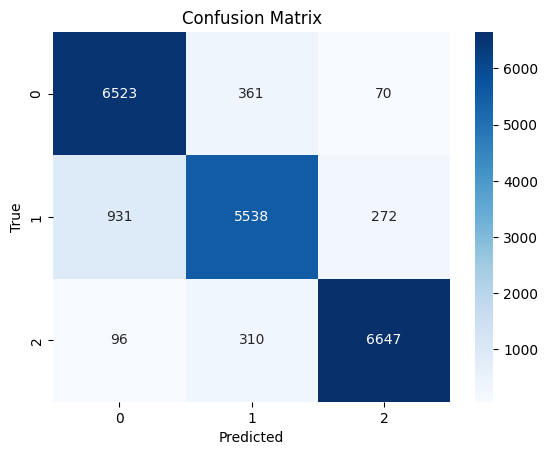

In [122]:
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2])  # Replace with your actual labels

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])  # Replace with your actual labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Summary**: The model has done a decent job in predicting true labels for negative and postive labels. However, there is bit more confusion around neutral reviews i.e. label 1. It was somewhat expected as well since the model gave similar results in val/test data too.

In [123]:
test_df['Predictions'] = all_preds

In [124]:
test_df

,Rating,Source,Sentiment,Content,word_count,predictions
0,4.0,PowerReviews,2,not sure yet. do not have the item,8,1
1,4.0,PowerReviews,2,it would be nice if i could finish shopping be...,14,0
2,4.0,PowerReviews,2,"seemless, so far. need to wait for delivery to...",12,2
3,4.0,PowerReviews,2,website slow.,2,1
4,4.0,PowerReviews,2,easy to use online system,5,2
...,...,...,...,...,...,...
20743,2.0,PowerReviews,0,not ideal. i phoned to ask about free 24hr del...,188,0
20744,2.0,PowerReviews,0,"depends, last time 'next day' delivery was not...",16,0
20745,2.0,PowerReviews,0,descriptions of products on the site is very g...,57,0
20746,2.0,PowerReviews,0,not the most user friendly website.,6,0


In [128]:
plot_names_true = test_df.Sentiment.value_counts().keys()
plot_values_true = test_df.Sentiment.value_counts().values

plot_names_pred = test_df.Predictions.value_counts().keys()
plot_values_pred = test_df.Predictions.value_counts().values

print(plot_names_true, plot_values_true)
print()
print(plot_names_pred, plot_values_pred)

Index([2, 0, 1], dtype='int64', name='Sentiment') [7053 6954 6741]

Index([0, 2, 1], dtype='int64', name='Predictions') [7550 6989 6209]


### **True vs Actual Predictions Histogram**

In [129]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='True Labels', x=plot_names_true, y=plot_values_true),
    go.Bar(name='Predictions', x=plot_names_pred, y=plot_values_pred)
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

### **Saving Predictions**

In [ ]:
test_df.to_csv("/kaggle/working/final_bert_predictions.csv", index=False)